# ЛР3. NB, LR, SVM

In [164]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

In [165]:
# Создадим DataFrame train_df из CSV train.csv
train_df = pd.read_csv("../csv/train.csv")

# Создадим DataFrame test_df из CSV test.csv
test_df = pd.read_csv("../csv/test.csv")

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [166]:
# Посчитайте количество объектов в DF train и test
# количество объектов в train_df
print(train_df.shape[0])

# количество объектов в test_df
print(test_df.shape[0])

891
418


<font color=red>  Примечание. В тестовых данных нет целевой переменной (т. е. столбец «Survival» отсутствует), поэтому цель состоит в том, чтобы предсказать эту переменную с использованием различных алгоритмов машинного обучения, таких как логистическая регрессия. </font>

In [167]:
# Проверьте, есть ли в данных train_df пропущенные значения
print(train_df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Давайте разберемся с графиой "Age"
Ответьте на вопросы и сделайте следующие дейтсвия

Сколько процентов значений пропущено?
Найдите медиану и среднее значение переменной.
Постойте гистаграмму.
Какое значение больше: медиана или среднее?

Процент пропущенных значений в столбце 'Age': 19.865319865319865 %
Медиана возраста: 28.0
Средний возраст: 29.69911764705882


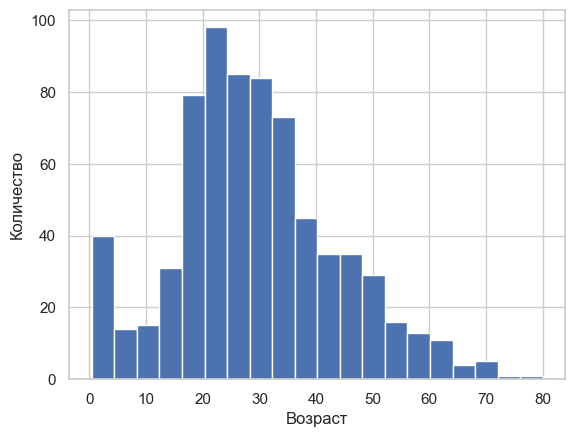

In [168]:
# процент пропущенных значений
print("Процент пропущенных значений в столбце 'Age':", train_df['Age'].isna().sum() / len(train_df) * 100, "%")

# медиана и среднее значение
median_age = train_df['Age'].median()
mean_age = train_df['Age'].mean()
print("Медиана возраста:", median_age)
print("Средний возраст:", mean_age)

# построение гистограммы
plt.hist(train_df['Age'], bins=20)
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

Так как график распределения смещён вправа, использование среднего значения может дать нам необъективные результаты из-за заполнения возрастов, которые старше желаемого. Чтобы справиться с этим, мы будем использовать медиану для вменения пропущенных значений.

Давайте разберемся с графиой "Cabin"

Сколько процентов значений пропущено?

In [169]:
# процент пропущенных значений
print("Процент пропущенных значений в столбце 'Cabin':", train_df['Cabin'].isna().sum() / train_df.shape[0] * 100, "%")


Процент пропущенных значений в столбце 'Cabin': 77.10437710437711 %


<font color=green>  Если в столбце больше половины пропусков, то он не информативен для нас. В дальнейшем мы его уберем </font>

Давайте разберемся с графиой "Embarked"

Сколько процентов значений пропущено?

In [170]:
# процент пропущенных значений
print("Процент пропущенных значений в столбце 'Embarked':", train_df['Embarked'].isna().sum() / train_df.shape[0] * 100, "%")


Процент пропущенных значений в столбце 'Embarked': 0.22446689113355783 %


In [171]:
train_data = train_df.copy()

Основываясь на оценке отсутствующих значений в наборе данных, внесите в данные следующие изменения:

Если в строке отсутствует «Age», вставьте средний возраст.
Если отсутствует «Embarked», замените его на наиболее распространенный порт посадки.
Удалите столбец "Cabin"

In [172]:
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)

most_common_embarked = train_data['Embarked'].mode().iloc[0]
train_data['Embarked'].fillna(most_common_embarked, inplace=True)

train_data.drop('Cabin', axis=1, inplace=True)

Выполните проверку на пустые значения. Таковых остаться не должно

In [173]:
# проверка результатов
print(train_data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Согласно словарю данных Kaggle, и SibSp, и Parch относятся к путешествиям с семьей. Для простоты (и для учета возможной мультиколлинеарности) я объединим влияние этих переменных в один категориальный предиктор: путешествовал ли этот человек один или нет (0 или 1).
Не забудьте удалить SibSp и Parch (Пока работаем с train_data)

In [174]:
train_data['TravelAlone'] = np.where((train_data['SibSp'] + train_data['Parch']) > 0, 0, 1)
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,TravelAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,1


также создадим категориальные переменные для класса пассажира ("Pclass"), пола ("Sex") и порта посадки ("Embarked").
Используем функцию pd.get_dummies
Не забудьте удалить колонки, из которых делаете dummie-переменные

In [175]:
pclass_dummies = pd.get_dummies(train_data['Pclass'], prefix='Pclass')
sex_dummies = pd.get_dummies(train_data['Sex'], prefix='Sex')
embarked_dummies = pd.get_dummies(train_data['Embarked'], prefix='Embarked')
training = pd.concat([train_data, pclass_dummies, sex_dummies, embarked_dummies], axis=1)

training.drop(['Pclass','Sex','Embarked'],axis=1, inplace=True)

final_train = training.copy()
final_train.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,0,0,0,1,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,0,1,0,0,1,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,1,0,0,1,1,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,0,1,0,0,1,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,373450,8.0500,1,0,0,1,0,1,0,0,1


Теперь примените те же изменения к тестовым данным.

Применим то же значение для «Возраст» в тестовых данных, что и для моих данных обучения (если отсутствует, возраст = 28).
Уберем «Cabin» из тестовых данных
В переменной порта "Embarked" не было пропущенных значений.
Добавим dummie переменные.
Наконец, заполним 1 пропущенное значение для «Fare» с медианой 14,45.

In [176]:
test_data = test_df.copy()
test_data['Age'].fillna(28, inplace=True)

test_data.drop('Cabin', axis=1, inplace=True)

test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

test_data['TravelAlone'] = np.where((test_data['SibSp'] + test_data['Parch']) > 0, 0, 1)
test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

pclass_dummies = pd.get_dummies(test_data['Pclass'], prefix='Pclass')
sex_dummies = pd.get_dummies(test_data['Sex'], prefix='Sex')
embarked_dummies = pd.get_dummies(test_data['Embarked'], prefix='Embarked')

test_training = pd.concat([test_data, pclass_dummies, sex_dummies, embarked_dummies], axis=1)

test_training.drop(['Pclass','Sex','Embarked'],axis=1, inplace=True)


final_test = test_training.copy()
final_test.head()

,PassengerId,Name,Age,Ticket,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,"Kelly, Mr. James",34.5,330911,7.8292,1,0,0,1,0,1,0,1,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,363272,7.0000,0,0,0,1,1,0,0,0,1
2,894,"Myles, Mr. Thomas Francis",62.0,240276,9.6875,1,0,1,0,0,1,0,1,0
3,895,"Wirz, Mr. Albert",27.0,315154,8.6625,1,0,0,1,0,1,0,0,1
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,3101298,12.2875,0,0,0,1,1,0,0,0,1


Оцените выживаемость Пассажиров до 16 лет

In [177]:
passengers_under_16 = final_train[final_train['Age'] <= 16]
survived_under_16 = passengers_under_16['Survived'].sum()
total_under_16 = passengers_under_16['Survived'].count()
survival_rate_under_16 = survived_under_16 / total_under_16

print(round(survival_rate_under_16 * 100,2))

55.0


Учитывая выживаемость пассажиров моложе 16 лет,включим в свой набор данных еще одну категориальную переменную: «IsMinor». Значение 1 - если меньше 16 лет, 0 - если больше

In [178]:
final_train['IsMinor']=np.where(final_train['Age'] < 16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age'] < 16, 1, 0)

Определите самый безопасный класс
Определите, кому удаолсь выжить с большей вероятностью: кто путешествовал в одиночку или нет

In [179]:
def class_surv(suffix):
    passengers = final_train[final_train[f'Pclass_{suffix}'] == 1]
    surv_passengers = passengers['Survived'].sum()
    total_passengers = passengers['Survived'].count()
    rate = surv_passengers / total_passengers
    return round(rate*100, 2)

for i in range(1,4):
    print(f'Pclass_{i} -- {class_surv(i)}%')

Pclass_1 -- 62.96%
Pclass_2 -- 47.28%
Pclass_3 -- 24.24%



##  Выбор признаков для анализа


### Рекурсивное устранение признаков

рекурсивное исключение функций (RFE) заключается в выборе функций путем рекурсивного рассмотрения все меньших и меньших наборов функций. Во-первых, оценщик обучается на начальном наборе признаков, и важность каждого признака определяется либо с помощью атрибута «coef_», либо с помощью атрибута «feature_importances_». Затем наименее важные функции удаляются из текущего набора функций. Эта процедура рекурсивно повторяется для сокращенного набора до тех пор, пока в конечном итоге не будет достигнуто желаемое количество функций для выбора.

Изучите материалы ниже

 <br>
 https://www.helenkapatsa.ru/kross-validatsiia/ <br>
 https://www.codecamp.ru/blog/cross-validation-k-fold/ <br>
http://scikit-learn.org/stable/modules/feature_selection.html <br>

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']
# Создайте logreg и вычислите важность функций
model = LogisticRegression()
# создайте модель RFE и выберите 8 атрибутов
rfe = RFE(model, n_features_to_select=8, step=1)
rfe = rfe.fit(X, y)
# резюмируем  выбор атрибутов
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


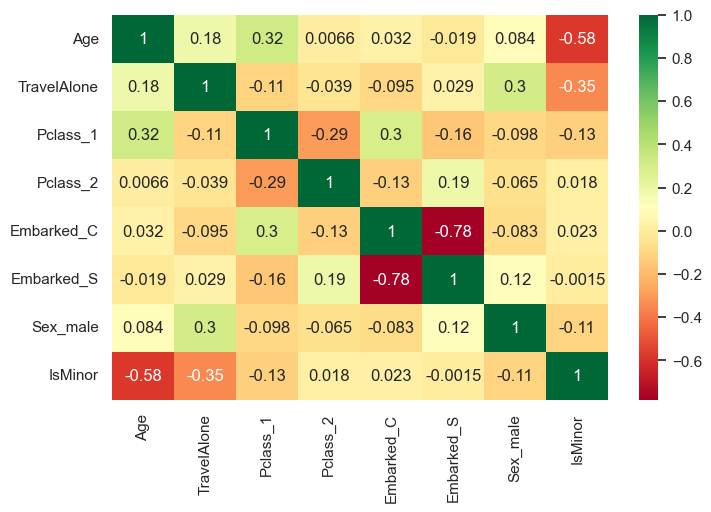

In [181]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

'''
Данный код строит тепловую карту (heatmap) корреляций между 
переменными, выбранными в Selected_features.

X.corr() вычисляет корреляционную матрицу для этих переменных.
Коэффициенты корреляции отображаются на тепловой карте, где
синий цвет указывает на отрицательную корреляцию, 
красный - на положительную,
а цвет близкий к нулю - на отсутствие корреляции между переменными.

annot=True означает, что значения коэффициентов корреляции 
будут отображаться в ячейках тепловой карты.

cmap="RdYlGn" задает цветовую карту, где красный означает 
более высокую корреляцию, а зеленый - менее высокую.

Итоговая тепловая карта дает представление о том, какие 
переменные коррелируют друг с другом, что может помочь 
в выборе переменных для использования в модели.
'''
print() # Чтобы жупитэр не выводил всякое __docstring__ после выполнения кода

## представьте, перед вами стоит задача оценки качества работы модели машинного обучения и сравнения таких моделей межд собой

идея: разделение датасета на выборку для обучения и тестирования

### Оценка модели на основе простого разделения train/test с использованием функции `train_test_split()`

In [182]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
X = final_train[Selected_features]
y = final_train['Survived']

# можно использовать разделение обучения/тестирования с разными значениями random_state
# мы можем изменить значения random_state, которые изменят показатели точности
# результаты сильно меняются, поэтому результаты тестирования являются оценкой с высокой дисперсией
# test_size разделяет выборку на тестовую и убучающую в соотношении 20/80
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

'''

Этот код оценивает производительность модели
логистической регрессии на тестовом наборе данных.

Сначала модель обучается на обучающем наборе данных (X_train и y_train),
затем применяется на тестовом наборе данных (X_test)
для предсказания меток классов (y_pred) и вероятностей принадлежности 
к классу 1 (y_pred_proba).

Далее рассчитываются метрики производительности модели,
такие как accuracy (точность), 
log_loss (логистическая потеря) и auc (площадь под кривой ROC).

Наконец, эти метрики выводятся на экран вместе с именем модели (logreg).

'''
print() # Чтобы жупитэр не выводил всякое __docstring__ после выполнения кода


Train/Test split results:
LogisticRegression accuracy is 0.788
LogisticRegression log_loss is 0.503
LogisticRegression auc is 0.838



### Оценка модели на основе K-fold cross-validation с использованием функции cross_val_score()

In [183]:
# 10-fold cross-validation logistic regression
logreg = LogisticRegression()
# Используем cross_val_score function
# Мы передаём полные X and y, а не X_train и y_train, функция сама разбивает данные
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} в качестве метрик оценивания результата (есть и другие)
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

'''
Этот код выполняет оценку качества модели с
помощью метода кросс-валидации (k-fold cross-validation). 
Модель logreg используется для предсказания целевой переменной 
на наборе данных X с помощью 10-кратной кросс-валидации. 
Для оценки качества модели используются три метрики: accuracy, log_loss и roc_auc.

    - cross_val_score используется для вычисления показателей качества модели для каждой итерации разбиения данных в кросс-валидации

    - Параметр cv=10 указывает на использование 10-кратной кросс-валидации

    - scoring параметр указывает на метрику, используемую для оценки качества модели
    
    - Затем выводятся средние значения каждой метрики для модели logreg после 10-кратной кросс-валидации.
'''
print() # Чтобы жупитэр не выводил всякое __docstring__ после выполнения кода

K-fold cross-validation results:
LogisticRegression average accuracy is 0.801
LogisticRegression average log_loss is 0.454
LogisticRegression average auc is 0.850



### Оценка модели на основе K-fold cross-validation с использованием функции cross_validate()

In [184]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))
    
'''
Этот код использует метод перекрестной проверки (cross-validation)
для оценки производительности модели машинного обучения.
Модель используется для классификации, и для оценки 
производительности используются метрики accuracy, log_loss и auc.

В первой части кода используется метод cross_val_score,
который разбивает данные на k блоков и выполняет обучение
и тестирование k раз, используя каждый блок в качестве тестового набора.
Затем выводятся результаты средней точности, среднего log_loss и средней auc по всем блокам.

Во второй части кода используется метод cross_validate,
который также использует метод перекрестной проверки для
оценки производительности модели, но с возможностью задания 
нескольких метрик производительности. Результаты выводятся 
в виде таблицы, содержащей средние значения и стандартные отклонения 
каждой метрики для каждого блока.
'''
print() # Чтобы жупитэр не выводил всякое __docstring__ после выполнения кода

K-fold cross-validation results:
LogisticRegression average accuracy: 0.801 (+/-0.028)
LogisticRegression average log_loss: 0.454 (+/-0.039)
LogisticRegression average auc: 0.850 (+/-0.029)




Формула Байеса


$$
P (A | B) = \frac{P ( B ∣ A ) P ( A )}{P ( B )}
$$


    где

        P ( A ) P(A) — априорная вероятность гипотезы A (смысл такой терминологии см. ниже);
        P ( A ∣ B ) — вероятность гипотезы A при наступлении события B (апостериорная вероятность);
        P ( B ∣ A )  — вероятность наступления события B при истинности гипотезы A;
        P ( B ) P(B) — полная вероятность наступления события B.



In [185]:
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [186]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

'''
Этот код обучает классификатор на данных X_train и метках классов y_train
с помощью наивного байесовского классификатора GaussianNB.
После обучения классификатора, он может использоваться для классификации новых данных.
'''
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print() # Чтобы жупитэр не выводил всякое __docstring__ после выполнения кода

In [187]:

def cross_validate(estimator, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))
    
cross_validate(classifier, (X_train, y_train), (X_test, y_test))

'''
Этот код определяет функцию cross_validate, которая принимает на вход модель estimator
и разбивает данные на train и validation.
Затем модель используется для предсказания на train и validation, 
после чего вычисляются метрики качества (accuracy, recall, precision)
на обоих наборах данных и выводятся на экран.
Эта функция позволяет оценить качество модели на обучающих и проверочных данных.

В данном случае функция вызывается с аргументами 
    - classifier - обученной моделью GaussianNB, 
    - (X_train, y_train) - обучающим набором данных
    - (X_test, y_test) - проверочным набором данных.
Функция cross_validate выводит метрики качества модели на обоих наборах данных.
'''
print() # Чтобы жупитэр не выводил всякое __docstring__ после выполнения кода

Model metrics
Accuracy  Train: 0.78, Validation: 0.77
Recall    Train: 0.68, Validation: 0.76
Precision Train: 0.78, Validation: 0.68



## SVM

In [188]:
from sklearn import svm
# Объявление SVC без настройки
classifier = svm.SVC()

# Подгонка данных. Это то, чему SVM научится
classifier.fit(X_train, y_train)

# Прогнозирование результата и получение точности
score = classifier.score(X_test, y_test)

print(score)

0.5698324022346368


In [189]:
#Посчитайте score, если train set будет состоять только из 3 переменных: ['Sex', 'Age', 'Pclass']


# Разделить данные на признаки и целевую переменную
X = final_train[['Sex_male', 'Age', 'Pclass_1']] # немного не понял задание, надо только один Pclass выбрать или все Pclass? в целом, результат никак не изменяется, поэтому оставил так
y = final_train['Survived']

# разделение на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели и расчет score
svc = svm.SVC()
svc.fit(X_train, y_train)
score = svc.score(X_test, y_test)

print(score)

0.6089385474860335
